# Tracking the Cyclonic and Anticyclonic eddies sampled during the OTC23 course

This notebook is a part of the Ocean Training Course 2023, Working Group 2. It's main goal is to select and characterize the _life_ of two eddies sampled during the on board session.

<div class="alert alert-warning">
    <strong>To run this notebook, you will need:</strong>
    
* A directory `obs_datadir` with the a collection of cyclonic eddy detection files written by py-eddy-tracker library. For instance, using the python script _"../scripts/eddy-identification.py"_
* A directory `gos_datadir` where the CMEMS altimetry datasets are stored
* Fill the three dictionnaries `c_eddy1_end`, `c_eddy2_end` and `merged_start`: each of these define a point (lat,lon,time) needed to extract the desired trajectories from all
</div>

### User options

In [1]:
# I/O options
obs_datadir = r'../../observations/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/sla/'
gos_datadir = r'../../datas/cmems/'
gos_product = {'MY': 'SEALEVEL_GLO_PHY_L4_MY_008_047', 
               'NRT': 'SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046'
              }

bathy_dir   =  r'../../datas/to_ESA/data_seascope/bathymetry_gebco/'
bathy_file  = []

# JSON additional informations
plot_json   = False
i_stations  = [38, 40, 42]

# Tracks detection
merged_start = {'lon': 30.2, 'lat': -34.6, 'time': 26669.}
c_eddy1_end  = {'lon': 34.7, 'lat': -33.8, 'time': 26539.}
c_eddy2_end  = {'lon': 35.1, 'lat': -32.6, 'time': 26539.}
ac_eddy_end  = {'lon': 31.3, 'lat': -33.5, 'time': 26668.}

# Box definitions
box_south_agulhas = {'longitude': (26, 36), 'latitude': (-37, -32)}
box_semc          = {'longitude': (42.5, 47.5), 'latitude': (-28, -25)}

# Anomalies calculation
time_period  = ('2003-01-01', '2022-12-31')

# logger type
logger_type = 'ERROR'   # (py-eddy-tracker) Available options: ERROR, WARNING, INFO, DEBUG

In [2]:
# Constants
earth_radius = 6371229.

### Import necessary modules

In [3]:
import copy
import glob
import json
import os
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.path import Path
from shapely.geometry.polygon import LinearRing

from py_eddy_tracker import start_logger
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.poly import create_vertice
from py_eddy_tracker.tracking import Correspondances

start_logger().setLevel(logger_type)

### function definition

In [4]:
def select_closest_track(eddies, lon, lat, time=None):
    """select a track which pass close to a lon,lat point."""
    
    if time is None:
        nan_mask = np.ones_like(eddies.amplitude)
    else:
        cnd_time = (eddies.time == time)
        nan_mask = np.where(cnd_time, 1., np.nan)

    distance = ((eddies.lon - lon)**2. + (eddies.lat - lat)**2.)**0.5
    distance *= nan_mask

    obsindex = np.nanargmin(distance)
    track_id = eddies.tracks[obsindex]

    track    = eddies.extract_ids([track_id])
    
    return track

def add_field_to_track(track, dataset, variable, grid):
    """add a field like array with in a specified track"""
    
    if variable in track.__dict__:
        raise Exception("Field '{}' already in track".format(variable))
        
    x_name, y_name = track.intern(False)
    field = np.zeros_like(track.amplitude)

    for i, time in enumerate(track.time):
        dtime = datetime(1950, 1, 1) + time * timedelta(days=1)
        itime = np.where(dataset['eke'].time == np.datetime64(dtime))[0]

        vals = dataset[variable].isel({'time': int(itime)}).to_masked_array()
        pxls = Path(create_vertice(track[x_name][i], track[y_name][i])).pixels_in(grid)
        mask = np.zeros(vals.shape, dtype=bool)

        mask[pxls[1], pxls[0]] = True
        vals.mask[:]           = ~mask
        field[i]               = np.ma.sum(vals)
    
    track.__dict__[variable] = field
    

def linear_ring_from_box(box):
    """return a LinearRing polygon object from a given box to plot in maps"""
    lon_min, lon_max = box['longitude']
    lat_min, lat_max = box['latitude']
    
    return LinearRing([(lon_min, lat_min), 
                       (lon_max, lat_min), 
                       (lon_max, lat_max), 
                       (lon_min, lat_max)])

def export_track(track, filename):
    """write numpy arrays in file."""
    datas = np.zeros((len(track.time), 4))
    datas[:, 0] = track.time
    datas[:, 1] = track.lon
    datas[:, 2] = track.lat
    datas[:, 3] = track.speed_radius
    
    np.savetxt(filename, datas, header="time,lon,lat,speed_radius", delimiter=',')


def to_datetime(days):
    """convert a number of days after 1950-01-01 to the equivalent datetime"""
    
    return datetime(1950, 1, 1) + days * timedelta(days=1)


## Focus on the cyclonic eddy formation

In [5]:
# First, select the cyclonic eddies track (before and after merging)
# -- all the files in 'obs_datadir' will be loaded
cycl_files = glob.glob(os.path.join(obs_datadir, 'Cyclonic_*'))
acyc_files = glob.glob(os.path.join(obs_datadir, 'Anticyclonic_*'))

c = Correspondances(datasets=sorted(cycl_files[:]), class_method=AreaTracker, virtual=3)
c.track()
c.prepare_merging()

a = Correspondances(datasets=sorted(acyc_files[:]), class_method=AreaTracker, virtual=3)
a.track()
a.prepare_merging()

# -- here, we get a collection of cyclonic eddies
tracked = c.merge(raw_data=False)
tracked.virtual[:] = tracked.time == 0
tracked.filled_by_interpolation(tracked.virtual == 1.)

# -- select a track which pass close to a lon,lat,time point
c_mrged_track = select_closest_track(tracked, **merged_start)
c_eddy1_track = select_closest_track(tracked, **c_eddy1_end)
c_eddy2_track = select_closest_track(tracked, **c_eddy2_end)

# -- same for the anticyclonic eddies
tracked = a.merge(raw_data=False)
tracked.virtual[:] = tracked.time == 0
tracked.filled_by_interpolation(tracked.virtual == 1.)

ac_eddy_track = select_closest_track(tracked, **ac_eddy_end)

In [6]:
# Load syntool extracted track (can be used for comparison/validation)
syn_lons = list()
syn_lats = list()
    
list_syn = glob.glob(os.path.join(obs_datadir, '../../*Cyclonic*.json'))
for synf in sorted(list_syn):
    with open(synf, 'r') as f:
        user_shape = json.load(f)[0]

    syn_lons.append(user_shape['center'][0])
    syn_lats.append(user_shape['center'][1])
    
otc_lons = list()
otc_lats = list()

list_syn = glob.glob(os.path.join(obs_datadir, '../../*OTC23_cruise_track.json'))
for synf in sorted(list_syn):
    with open(synf, 'r') as f:
        user_shape = json.load(f)[0]
    
    for p in user_shape['points']:
        otc_lons.append(p[0])
        otc_lats.append(p[1])

In [7]:
# Load altimetry datasets
list_gos = list()
for ptype in gos_product:
    list_gos += glob.glob(os.path.join(gos_datadir, gos_product[ptype], '*.nc'))

# Load dataset and init grid object
ds       = xr.open_mfdataset(list_gos)
g        = RegularGridDataset(list_gos[0], "longitude", "latitude")

In [8]:
# Load bathymetry
bathy = None

if isinstance(bathy_file, list):
    bfiles = [os.path.join(bathy_dir, f) for f in bathy_file]
    if bfiles:
        bathy  = xr.open_dataset(bfiles[0])
        for f in bfiles[1:]:
            bathy = xr.concat( [bathy, xr.open_dataset(f)], dim='lon')

        if 'time' in bathy.dims:
            bathy = bathy.isel({'time': 0})
            
elif os.path.isfile(os.path.join(bathy_dir, bathy_file)):
    bathy = xr.open_dataset(os.path.join(bathy_dir, bathy_file))
    if 'time' in bathy.dims:
        bathy = bathy.isel({'time': 0})

### Compute the eddy kinetic energy (EKE)

In [9]:
# First compute the geostrophic anomalies
conds = ( ds['time'] >= np.datetime64(time_period[0]) )
conds = conds & ( ds['time'] <= np.datetime64(time_period[1]) )

ug    = ds['ugos'].isel({'time': np.where(conds)[0]})
vg    = ds['vgos'].isel({'time': np.where(conds)[0]})
sla   = ds['sla'].isel({'time': np.where(conds)[0]})

uga   = (ug - ug.mean('time'))
vga   = (vg - vg.mean('time'))

# EKE
eke   = 0.5*(uga**2. + vga**2.)
meke  = eke.mean('time').load()

# fill the dataset with the new variable
ds['eke']       = eke
ds['eke'].attrs = {'comment': 'Eddy Kinetic Energy (EKE) computed from geostrophic velocity anomalies with '
                              'respect to the period {}'.format(time_period),
                   'grid_mapping': 'crs',
                   'long_name': 'Surface eddy kinetic energy',
                   'standard_name': 'surface_eddy_kinetic_energy_from_geostrophic_velocity_anomalies',
                   'units' : 'm2/s2',
                  }

/home/torres/envs/eddy-hist/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [10]:
# Then, compute dx, dy needed for cell surfaces
glon, glat   = np.meshgrid(ds['longitude'], ds['latitude'])

dlon         = np.zeros(ds['longitude'].shape)
lon_bnds     = 0.5*(ds['longitude'][:-1].data + ds['longitude'][1:].data) 
dlon[1:-1]   = lon_bnds[1:] - lon_bnds[:-1]
dlon[0]      = 2 * (lon_bnds[0] - ds['longitude'][0])
dlon[-1]     = 2 * (ds['longitude'][-1] - lon_bnds[-1])

dlat         = np.zeros(ds['latitude'].shape)
lat_bnds     = 0.5*(ds['latitude'][:-1].data + ds['latitude'][1:].data) 
dlat[1:-1]   = lat_bnds[1:] - lat_bnds[:-1]
dlat[0]      = 2 * (lat_bnds[0] - ds['latitude'][0])
dlat[-1]     = 2 * (ds['latitude'][-1] - lat_bnds[-1])

dx = earth_radius * np.cos(glat * np.pi/180) * 2*np.pi * dlon/360.
dy = earth_radius * 2*np.pi * dlat/360.
dy = np.tile(dy, (glon.shape[1], 1)).transpose()

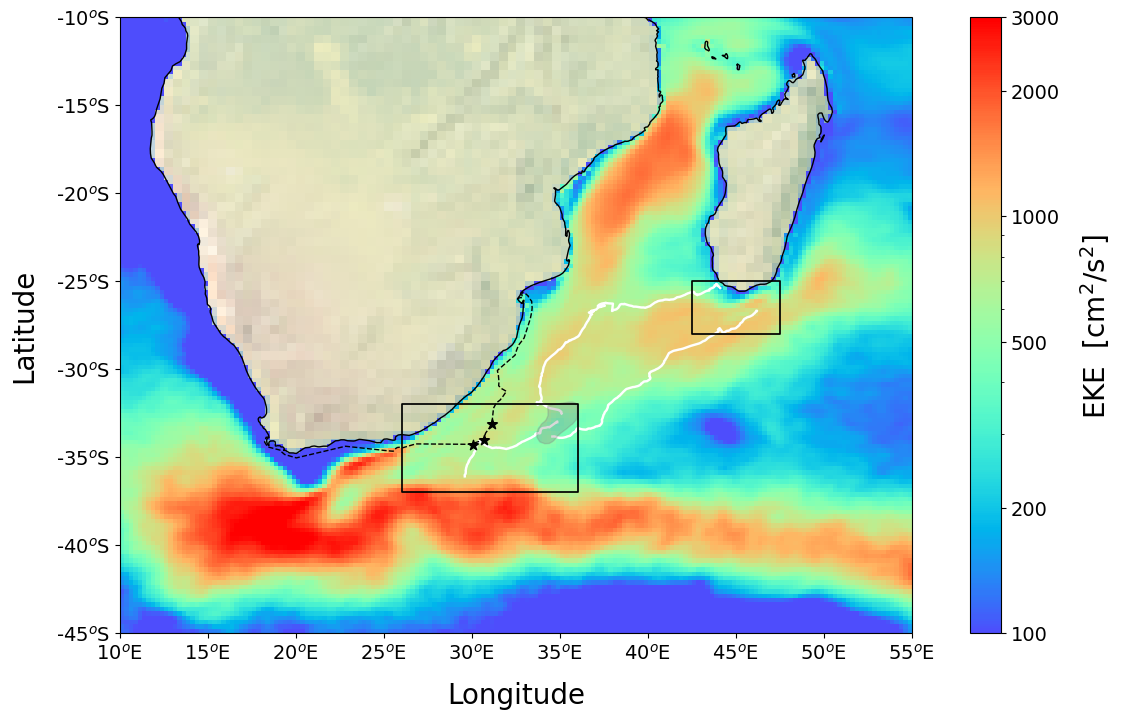

In [11]:
label_size = 20
tick_size  = 14

# Plot the eddy tracks
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([10, 55, -45, -10], crs=ccrs.PlateCarree())

ax.set_xlabel(r"Longitude", size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel(r"Latitude",  size=label_size, labelpad=int(label_size*2/3))

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
yticks = [-45, -40, -35, -30, -25, -20, -15, -10]
ax.set_xticks(xticks)
ax.set_xticklabels(['{}$^o$E'.format(x) for x in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels(['{}$^o$S'.format(y) for y in yticks])
ax.tick_params(labelsize=tick_size)

# -- add MEKE in ocean background
rainbow = plt.get_cmap('rainbow', 256)
newclrs = rainbow(np.linspace(0.1, 1, 256))
newcmp  = ListedColormap(newclrs)

mp = ax.pcolormesh(glon, glat, 10**4*meke, cmap=newcmp, norm=mcolors.LogNorm(vmin=100, vmax=3000))
cb = plt.colorbar(mp, ticks=[100, 200, 500, 1000, 2000, 3000], format="{x:d}")
cb.set_label(label=r'EKE  [cm$^2$/s$^2$]', size=label_size, labelpad=int(label_size*2/3))
cb.ax.tick_params(labelsize=tick_size)

# -- add bathymetry contours
if bathy is not None:
    lon_gcp = bathy['lon_gcp'][0] + bathy['lon']/bathy['lon'][-1] * (bathy['lon_gcp'][-1] - bathy['lon_gcp'][0])
    lat_gcp = bathy['lat_gcp'][0] + bathy['lat']/bathy['lat'][-1] * (bathy['lat_gcp'][-1] - bathy['lat_gcp'][0])

    blon, blat = np.meshgrid(lon_gcp, lat_gcp)
    
    z      = bathy['bathymetry']
    if 'lon_gcp' in z.dims:
        z = z.isel({'lon_gcp': 0})
    
    cs = ax.contour(blon, blat, z, levels=[-3500], colors=['gray'], linestyles='-')

# -- add eddy track
#ac_eddy_track.plot(ax, color="darkviolet", lw=1.5)
c_mrged_track.plot(ax, color="w", lw=1.75)
c_eddy1_track.plot(ax, color="w", lw=1.75)
c_eddy2_track.plot(ax, color="w", lw=1.75)

# -- add eddy contours
ax.fill(c_mrged_track.speed_contour_longitude[0], c_mrged_track.speed_contour_latitude[0], c=(0.5,0.5,0.5,0.3), 
        zorder=100)

# -- add OTC23 cruise track
ax.plot(otc_lons, otc_lats, 'k--', lw=1)
ax.scatter(np.array(otc_lons)[i_stations], np.array(otc_lats)[i_stations], 
           s=56, c="black", marker='*', zorder=100)

# -- add boxes
geom_agulhas = linear_ring_from_box(box_south_agulhas)
geom_semc    = linear_ring_from_box(box_semc)

ax.add_geometries([geom_agulhas, geom_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', lw=1.25, 
                  zorder=100)

plt.show()

In [12]:
fig.savefig('../../imgs/OTC23_Cyclonic_tracks_MEKE.png', dpi=300)

### Plot vorticity map

In [13]:
du_dy = ds['ugos'].differentiate('latitude')
dv_dx = ds['vgos'].differentiate('longitude')

vort  = dv_dx - du_dy

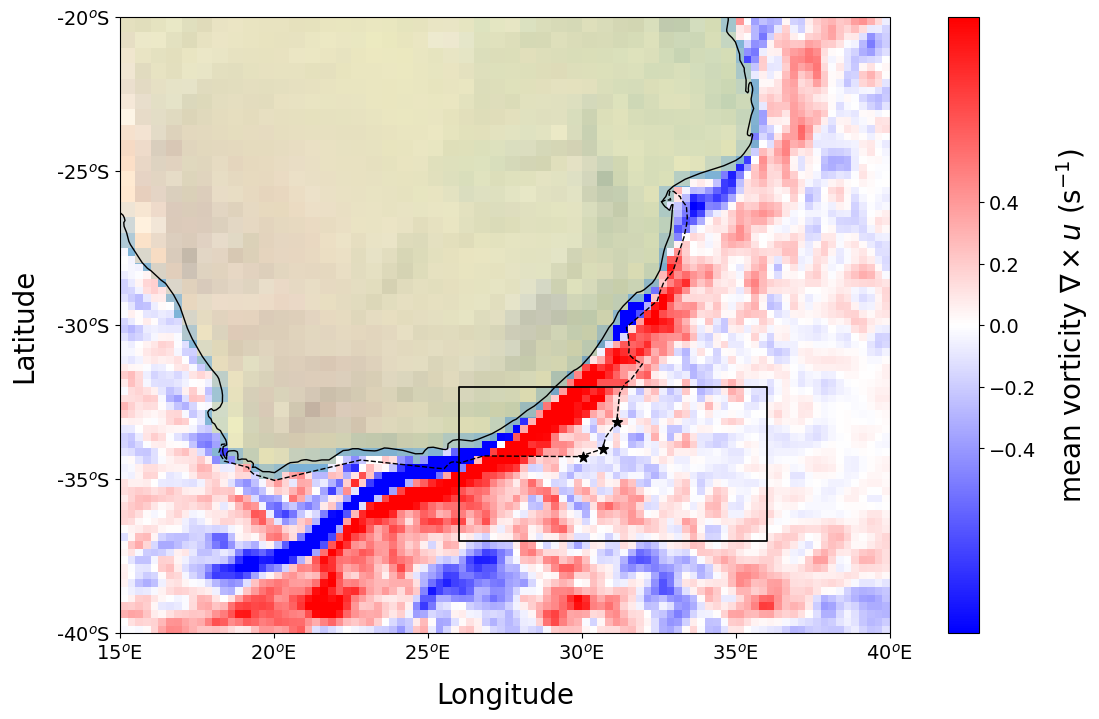

In [14]:
label_size = 20
tick_size  = 14

# Plot the eddy tracks
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([15, 40, -40, -20], crs=ccrs.PlateCarree())

ax.set_xlabel(r"Longitude", size=label_size, labelpad=int(label_size*2/3))
ax.set_ylabel(r"Latitude",  size=label_size, labelpad=int(label_size*2/3))

# -- background image on for nice sea rendering
ax.stock_img()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

xticks = [15, 20, 25, 30, 35, 40]
yticks = [-40, -35, -30, -25, -20]
ax.set_xticks(xticks)
ax.set_xticklabels(['{}$^o$E'.format(x) for x in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels(['{}$^o$S'.format(y) for y in yticks])
ax.tick_params(labelsize=tick_size)

# -- add MEKE in ocean background
mp = ax.pcolormesh(glon, glat, vort.mean('time'), cmap='bwr', vmin=-1, vmax=1, norm=None)
cb = plt.colorbar(mp, ticks=[-0.4, -0.2, 0, 0.2, 0.4])
cb.set_label(label=r'mean vorticity $\nabla \times u$ (s$^{-1}$)', size=label_size, labelpad=int(label_size*2/3))
cb.ax.tick_params(labelsize=tick_size)

# -- add OTC23 cruise track
ax.plot(otc_lons, otc_lats, 'k--', lw=1)
ax.scatter(np.array(otc_lons)[i_stations], np.array(otc_lats)[i_stations], 
           s=56, c="black", marker='*', zorder=100)

# -- add boxes
geom_agulhas = linear_ring_from_box(box_south_agulhas)
geom_semc    = linear_ring_from_box(box_semc)

ax.add_geometries([geom_agulhas, geom_semc], ccrs.PlateCarree(), facecolor='none', edgecolor='k', lw=1.25, 
                  zorder=100)

plt.show()

### Plot eddy characteristics evolution

In [15]:
# Save int(eke ds) in track field
add_field_to_track(c_eddy1_track, ds, 'eke', g)
add_field_to_track(c_eddy2_track, ds, 'eke', g)
add_field_to_track(c_mrged_track, ds, 'eke', g)

/tmp/ipykernel_1876/3254451585.py:39: UserWarning: Warning: converting a masked element to nan.
  field[i]               = np.ma.sum(vals)
/tmp/ipykernel_1876/3254451585.py:39: UserWarning: Warning: converting a masked element to nan.
  field[i]               = np.ma.sum(vals)
/tmp/ipykernel_1876/3254451585.py:39: UserWarning: Warning: converting a masked element to nan.
  field[i]               = np.ma.sum(vals)


In [25]:
# Pre process the datas
# -- merging zone
all_times = np.linspace(c_eddy1_track.time[0], c_mrged_track.time[-1], 200)
cds_merge = (datetime(2022,8,29) < to_datetime(all_times)) & (datetime(2022,9,10) > to_datetime(all_times))

# -- date for cyclonic and anticyclonic measurements
c_station = datetime(2023,1,8)
a_station = datetime(2023,1,7)

(-0.008029999304562808, 0.5206300021149218)

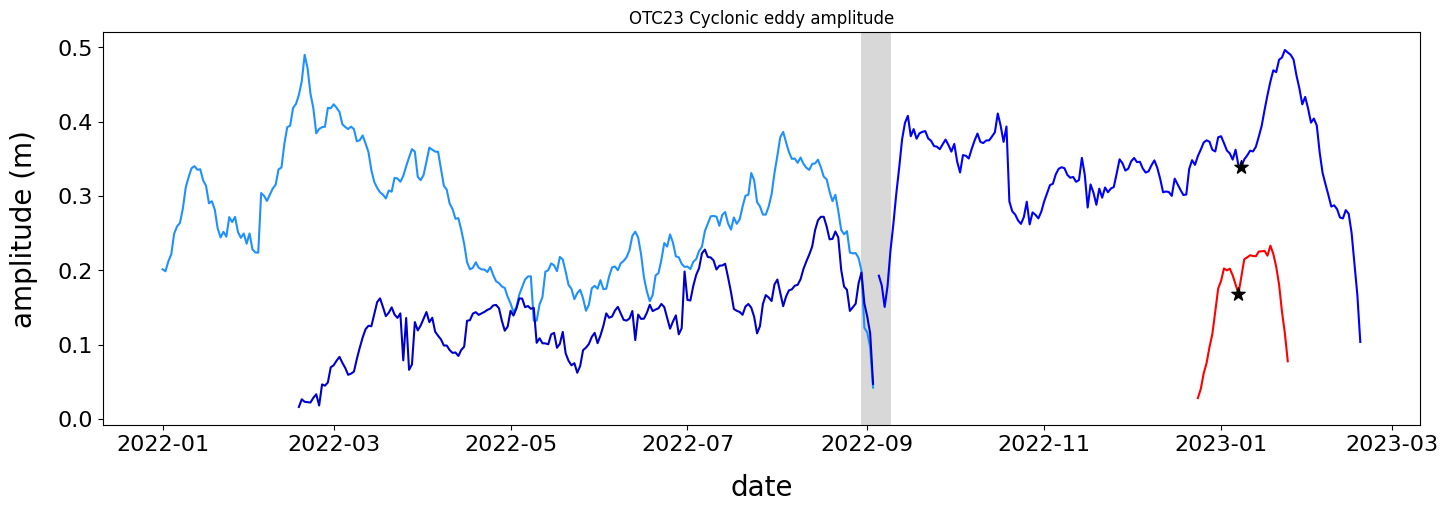

In [43]:
# Amplitude (in meter) 
fig = plt.figure(figsize=(17, 5.1))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy amplitude')
ax.set_xlabel('date', size=20, labelpad=14)
ax.set_ylabel('amplitude (m)', size=20, labelpad=14)
ax.tick_params(labelsize=16)

ax.plot(to_datetime(ac_eddy_track.time), ac_eddy_track.amplitude, c='red',     label='Anticyclonic')
ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.amplitude, c='dodgerblue', label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.amplitude, c='mediumblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.amplitude, c='blue',       label='Cyclonic merged')

ylim = ax.get_ylim()

# -- add merging shaded zone
ax.fill_between(to_datetime(all_times), ylim[0], ylim[1], where=cds_merge, 
                facecolor='grey', alpha=0.3)

# -- add OTC23 measurement
a_ind = np.where(to_datetime(ac_eddy_track.time) == a_station)[0]
ax.scatter(a_station, ac_eddy_track.amplitude[a_ind], s=100, c="black", marker='*', zorder=100)

c_ind = np.where(to_datetime(c_mrged_track.time) == c_station)[0]
ax.scatter(c_station, c_mrged_track.amplitude[c_ind], s=100, c="black", marker='*', zorder=100)

# -- final ax attributes
ax.set_ylim(ylim)
#ax.legend(prop={'size': 12})

In [44]:
fig.savefig('../../imgs/OTC23_Cyclonic_eddies_amplitude.png', dpi=300)

Cyclonic eddy 1 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  1.32 [mm/day]
Cyclonic eddy 2 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  0.76 [mm/day]
Merged cyclonic eddies trend computed from 2022-09-15 00:00:00 to 2023-02-04 00:00:00
  0.45 [mm/day]


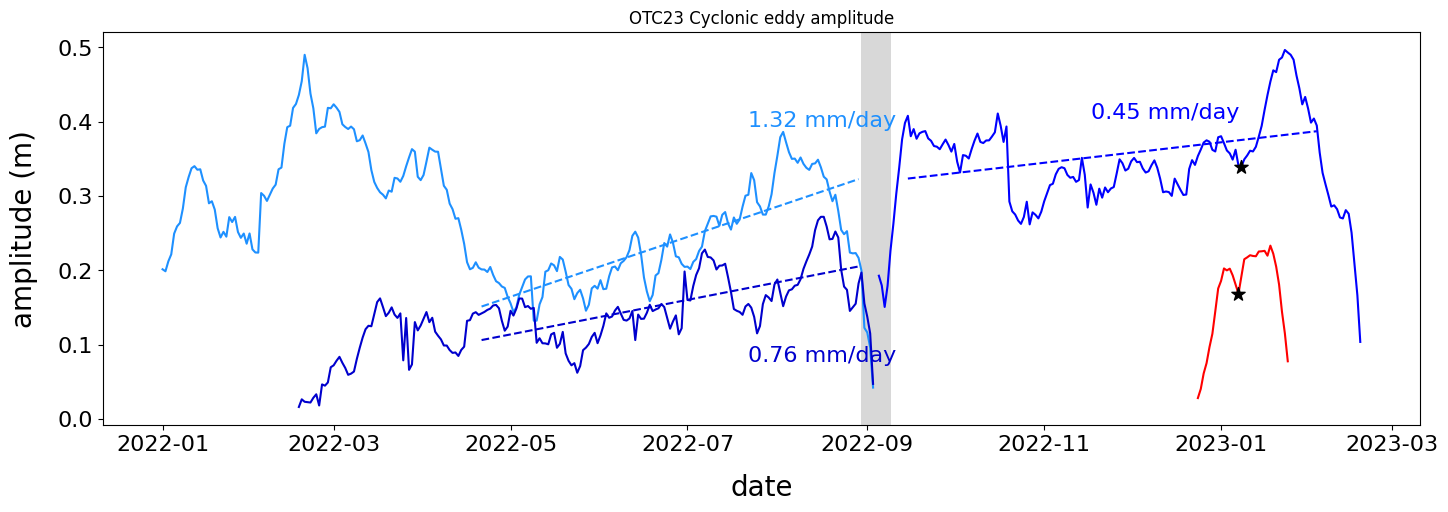

In [45]:
# Same figure but with trend lines
fig_trd = copy.deepcopy(fig)

# -- cyclonic eddy 1
i_ti  = 110
i_tf  = -5
ti    = to_datetime(c_eddy1_track.time[i_ti])
tf    = to_datetime(c_eddy1_track.time[i_tf])

trend = np.polyfit(c_eddy1_track.time[i_ti:i_tf], c_eddy1_track.amplitude[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 1 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [mm/day]".format(1e3*(p(2)-p(1))) )


fig_trd.axes[0].plot(to_datetime(c_eddy1_track.time[i_ti:i_tf]), p(c_eddy1_track.time[i_ti:i_tf]), 
                     "dodgerblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.8, "{:.2f} mm/day".format(1e3*(p(2)-p(1))), fontsize=16, c='dodgerblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- cyclonic eddy 2
i_ti  = 63
i_tf  = -5
ti    = to_datetime(c_eddy2_track.time[i_ti])
tf    = to_datetime(c_eddy2_track.time[i_tf])

trend = np.polyfit(c_eddy2_track.time[i_ti:i_tf], c_eddy2_track.amplitude[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 2 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [mm/day]".format(1e3*(p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_eddy2_track.time[i_ti:i_tf]), p(c_eddy2_track.time[i_ti:i_tf]),
                     "mediumblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.2, "{:.2f} mm/day".format(1e3*(p(2)-p(1))), fontsize=16, c='mediumblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- merged eddies
i_ti  = 10
i_tf  = -15
ti    = to_datetime(c_mrged_track.time[i_ti])
tf    = to_datetime(c_mrged_track.time[i_tf])

trend = np.polyfit(c_mrged_track.time[i_ti:i_tf], c_mrged_track.amplitude[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Merged cyclonic eddies trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [mm/day]".format(1e3*(p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_mrged_track.time[i_ti:i_tf]),  p(c_mrged_track.time[i_ti:i_tf]), 
                     "blue", linestyle='dashed')
fig_trd.axes[0].text(0.75, 0.82, "{:.2f} mm/day".format(1e3*(p(2)-p(1))), fontsize=16, c='blue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')


fig_trd

In [46]:
fig_trd.savefig('../../imgs/OTC23_Cyclonic_eddies_amplitude_with_trends.png', dpi=300)

(26.032500743865967, 141.91750955581665)

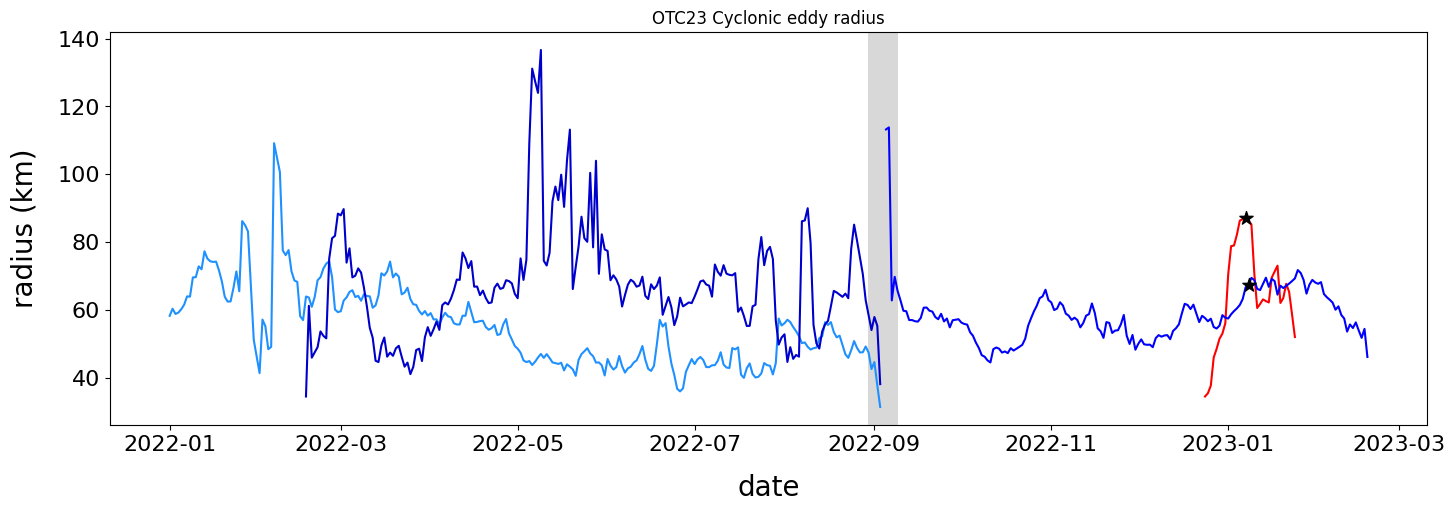

In [47]:
# Radius (in kilometer) 
fig = plt.figure(figsize=(17, 5.1))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy radius')
ax.set_xlabel('date', size=20, labelpad=14)
ax.set_ylabel('radius (km)', size=20, labelpad=14)
ax.tick_params(labelsize=16)

ax.plot(to_datetime(ac_eddy_track.time), 1e-3*ac_eddy_track.speed_radius, c='red',     label='Anticyclonic')
ax.plot(to_datetime(c_eddy1_track.time), 1e-3*c_eddy1_track.speed_radius, c='dodgerblue', label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), 1e-3*c_eddy2_track.speed_radius, c='mediumblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), 1e-3*c_mrged_track.speed_radius, c='blue',       label='Cyclonic merged')

ylim = ax.get_ylim()

# -- add merging shaded zone
ax.fill_between(to_datetime(all_times), ylim[0], ylim[1], where=cds_merge, 
                facecolor='grey', alpha=0.3)

# -- add OTC23 measurement
a_ind = np.where(to_datetime(ac_eddy_track.time) == a_station)[0]
ax.scatter(a_station, 1e-3*ac_eddy_track.speed_radius[a_ind], s=100, c="black", marker='*', zorder=100)

c_ind = np.where(to_datetime(c_mrged_track.time) == c_station)[0]
ax.scatter(c_station, 1e-3*c_mrged_track.speed_radius[c_ind], s=100, c="black", marker='*', zorder=100)

# -- final ax attributes
ax.set_ylim(ylim)
#ax.legend(prop={'size': 12})

In [48]:
fig.savefig('../../imgs/OTC23_Cyclonic_eddies_speed_radius.png', dpi=300)

Cyclonic eddy 1 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  18.45 [m/day]
Cyclonic eddy 2 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  -180.03 [m/day]
Merged cyclonic eddies trend computed from 2022-09-15 00:00:00 to 2023-02-04 00:00:00
  93.54 [m/day]


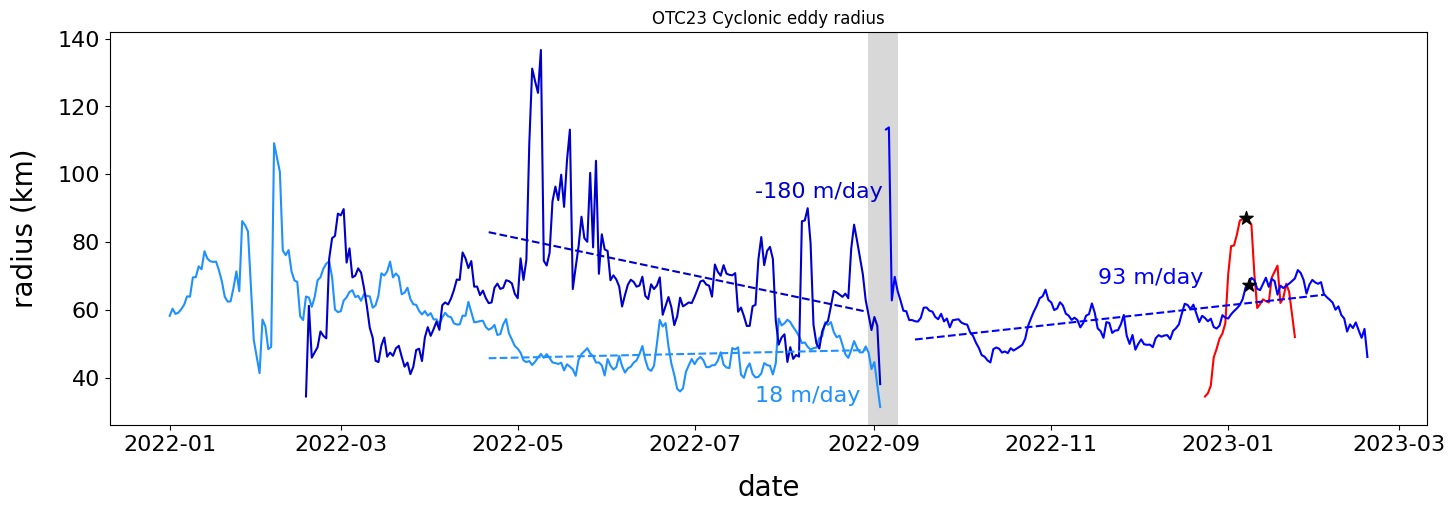

In [49]:
# Same figure but with trend lines
fig_trd = copy.deepcopy(fig)

# -- cyclonic eddy 1
i_ti  = 110
i_tf  = -5
ti    = to_datetime(c_eddy1_track.time[i_ti])
tf    = to_datetime(c_eddy1_track.time[i_tf])

trend = np.polyfit(c_eddy1_track.time[i_ti:i_tf], c_eddy1_track.speed_radius[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 1 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [m/day]".format((p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_eddy1_track.time[i_ti:i_tf]), 1e-3*p(c_eddy1_track.time[i_ti:i_tf]), 
                     "dodgerblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.1, "{} m/day".format(int((p(2)-p(1)))), fontsize=16, c='dodgerblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- cyclonic eddy 2
i_ti  = 63
i_tf  = -5
ti    = to_datetime(c_eddy2_track.time[i_ti])
tf    = to_datetime(c_eddy2_track.time[i_tf])

trend = np.polyfit(c_eddy2_track.time[i_ti:i_tf], c_eddy2_track.speed_radius[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 2 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [m/day]".format((p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_eddy2_track.time[i_ti:i_tf]), 1e-3*p(c_eddy2_track.time[i_ti:i_tf]),
                     "mediumblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.62, "{} m/day".format(int((p(2)-p(1)))), fontsize=16, c='mediumblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- merged eddies
i_ti  = 10
i_tf  = -15
ti    = to_datetime(c_mrged_track.time[i_ti])
tf    = to_datetime(c_mrged_track.time[i_tf])

trend = np.polyfit(c_mrged_track.time[i_ti:i_tf], c_mrged_track.speed_radius[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Merged cyclonic eddies trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [m/day]".format((p(2)-p(1))) )

trdline = fig_trd.axes[0].plot(to_datetime(c_mrged_track.time[i_ti:i_tf]), 1e-3*p(c_mrged_track.time[i_ti:i_tf]), 
                     "blue", linestyle='dashed')
fig_trd.axes[0].text(0.75, 0.4, "{} m/day".format(int((p(2)-p(1)))), fontsize=16, c='blue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

fig_trd

In [50]:
fig_trd.savefig('../../imgs/OTC23_Cyclonic_eddies_speed_radius_with_trends.png', dpi=300)

(0.08727999776601791, 0.9523199871182442)

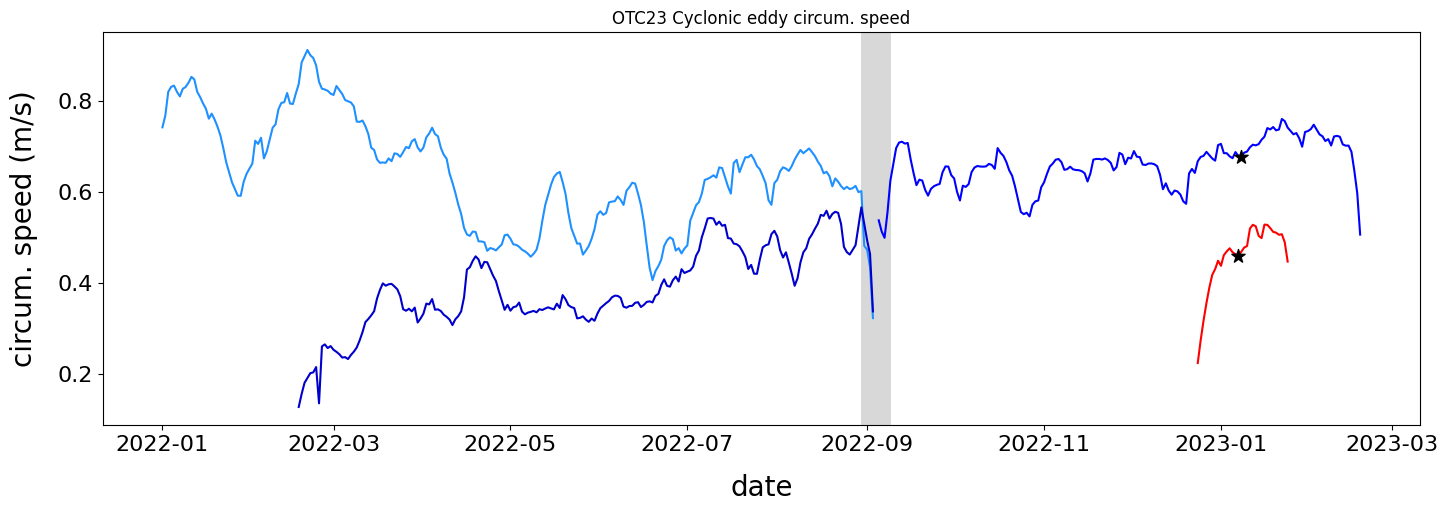

In [51]:
# Circum. speed (in m/s) 
fig = plt.figure(figsize=(17, 5.1))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy circum. speed')
ax.set_xlabel('date', size=20, labelpad=14)
ax.set_ylabel('circum. speed (m/s)', size=20, labelpad=14)
ax.tick_params(labelsize=16)

ax.plot(to_datetime(ac_eddy_track.time), ac_eddy_track.speed_average, c='red',     label='Anticyclonic')
ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.speed_average, c='dodgerblue', label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.speed_average, c='mediumblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.speed_average, c='blue',       label='Cyclonic merged')

ylim = ax.get_ylim()

# -- add merging shaded zone
ax.fill_between(to_datetime(all_times), ylim[0], ylim[1], where=cds_merge, 
                facecolor='grey', alpha=0.3)

# -- add OTC23 measurement
a_ind = np.where(to_datetime(ac_eddy_track.time) == a_station)[0]
ax.scatter(a_station, ac_eddy_track.speed_average[a_ind], s=100, c="black", marker='*', zorder=100)

c_ind = np.where(to_datetime(c_mrged_track.time) == c_station)[0]
ax.scatter(c_station, c_mrged_track.speed_average[c_ind], s=100, c="black", marker='*', zorder=100)

# -- final ax attributes
ax.set_ylim(ylim)
#ax.legend(prop={'size': 12})

In [52]:
fig.savefig('../../imgs/OTC23_Cyclonic_eddies_speed_average.png', dpi=300)

Cyclonic eddy 1 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  0.14 [cm/s/day]
Cyclonic eddy 2 trend computed from 2022-04-21 00:00:00 to 2022-08-30 00:00:00
  0.15 [cm/s/day]
Merged cyclonic eddies trend computed from 2022-09-15 00:00:00 to 2023-02-04 00:00:00
  0.07 [cm/s/day]


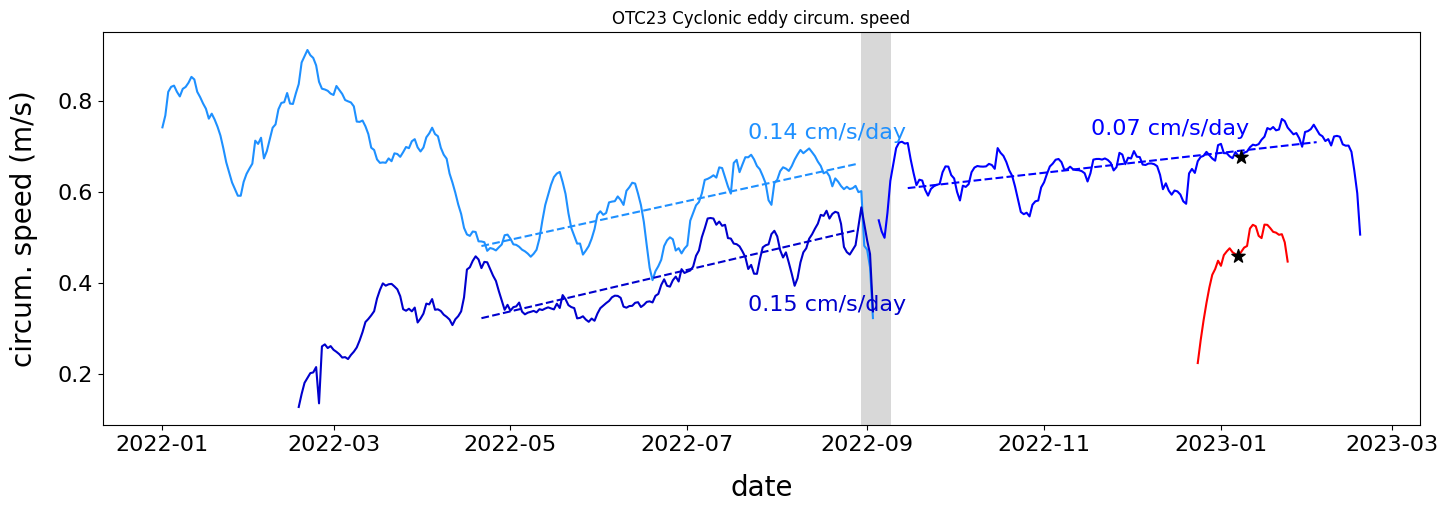

In [53]:
# Same figure but with trend lines
fig_trd = copy.deepcopy(fig)

# -- cyclonic eddy 1
i_ti  = 110
i_tf  = -5
ti    = to_datetime(c_eddy1_track.time[i_ti])
tf    = to_datetime(c_eddy1_track.time[i_tf])

trend = np.polyfit(c_eddy1_track.time[i_ti:i_tf], c_eddy1_track.speed_average[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 1 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [cm/s/day]".format(1e2*(p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_eddy1_track.time[i_ti:i_tf]), p(c_eddy1_track.time[i_ti:i_tf]), 
                     "dodgerblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.77, "{:.2f} cm/s/day".format(1e2*(p(2)-p(1))), fontsize=16, c='dodgerblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- cyclonic eddy 2
i_ti  = 63
i_tf  = -5
ti    = to_datetime(c_eddy2_track.time[i_ti])
tf    = to_datetime(c_eddy2_track.time[i_tf])

trend = np.polyfit(c_eddy2_track.time[i_ti:i_tf], c_eddy2_track.speed_average[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Cyclonic eddy 2 trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [cm/s/day]".format(1e2*(p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_eddy2_track.time[i_ti:i_tf]), p(c_eddy2_track.time[i_ti:i_tf]),
                     "mediumblue", linestyle='dashed')
fig_trd.axes[0].text(0.49, 0.33, "{:.2f} cm/s/day".format(1e2*(p(2)-p(1))), fontsize=16, c='mediumblue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')

# -- merged eddies
i_ti  = 10
i_tf  = -15
ti    = to_datetime(c_mrged_track.time[i_ti])
tf    = to_datetime(c_mrged_track.time[i_tf])

trend = np.polyfit(c_mrged_track.time[i_ti:i_tf], c_mrged_track.speed_average[i_ti:i_tf], 1)
p     = np.poly1d(trend)

print("Merged cyclonic eddies trend computed from {} to {}".format(ti, tf))
print("  {:.2f} [cm/s/day]".format(1e2*(p(2)-p(1))) )

fig_trd.axes[0].plot(to_datetime(c_mrged_track.time[i_ti:i_tf]), p(c_mrged_track.time[i_ti:i_tf]), 
                     "blue", linestyle='dashed')
fig_trd.axes[0].text(0.75, 0.78, "{:.2f} cm/s/day".format(1e2*(p(2)-p(1))), fontsize=16, c='blue',
                    transform=fig_trd.axes[0].transAxes, verticalalignment='top')


fig_trd

In [54]:
fig_trd.savefig('../../imgs/OTC23_Cyclonic_eddies_speed_average_with_trends.png', dpi=300)

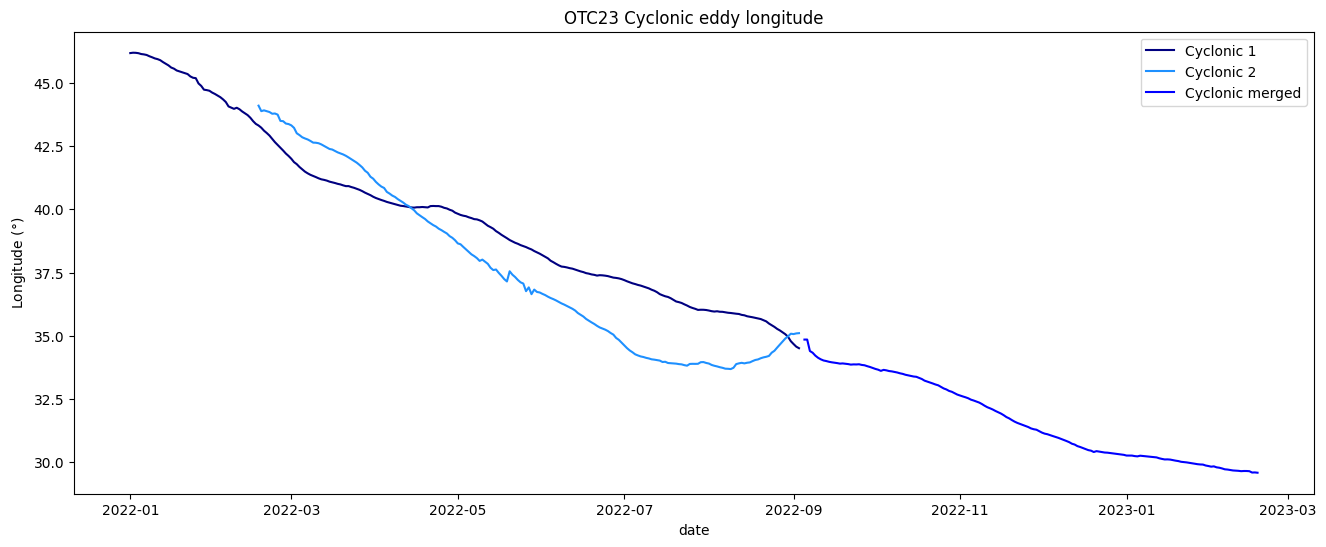

In [29]:
# Longitude (degree) 
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('OTC23 Cyclonic eddy longitude')
ax.set_xlabel('date')
ax.set_ylabel(r'Longitude ($\degree$)')

ax.plot(to_datetime(c_eddy1_track.time), c_eddy1_track.longitude, c='navy',       label='Cyclonic 1')
ax.plot(to_datetime(c_eddy2_track.time), c_eddy2_track.longitude, c='dodgerblue', label='Cyclonic 2')
ax.plot(to_datetime(c_mrged_track.time), c_mrged_track.longitude, c='b',     label='Cyclonic merged')

ax.legend()

In [30]:
fig.savefig('../../imgs/OTC23_Cyclonic_eddies_longitude_evolution.png', dpi=300)